In [31]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

In [2]:
# evaluating metric scores to measure variability and errors
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    return y_pred

In [28]:
# accuracy score calculation for each model
def evaluate_accuracy(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, np.round(y_pred))
    print(f"Accuracy: {accuracy:.4f}")
    return y_pred

In [29]:
# residual plot creation
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f'Residual Plot for {model_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

In [32]:
# ploting predictions vs actual results
def plot_prediction_vs_actual(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(f'Prediction vs Actual for {model_name}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

In [30]:
# plotting roc_curve
def plot_roc_curve(model, X_test, y_test, model_name):
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

In [3]:
# retrieving preprocessed file
df = pd.read_csv('../data/preprocessed_data.csv')
df = df.drop(columns=['Unnamed: 0'])
df = df.apply(pd.to_numeric, errors='coerce')
df.head()

,Make,Model,Year,Price,Cylinders,Transmission,Fuel Type,Rank,Coupe,Crossover,...,Grey,Orange,Other Color,Purple,Red,Silver,Tan,Teal,White,Yellow
0,3.375284,0.721931,1.899647,47819,4,1.0,2.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.659975,3.098285,1.381562,61250,4,1.0,2.0,4.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.434631,0.940014,3.108513,31861,4,1.0,2.0,5.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.600628,0.451207,1.899647,110322,4,1.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3.375284,2.030430,2.590428,139994,4,0.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  10000 non-null  float64
 1   Model                 10000 non-null  float64
 2   Year                  10000 non-null  float64
 3   Price                 10000 non-null  int64  
 4   Cylinders             10000 non-null  int64  
 5   Transmission          10000 non-null  float64
 6   Fuel Type             10000 non-null  float64
 7   Rank                  10000 non-null  float64
 8   Coupe                 10000 non-null  float64
 9   Crossover             10000 non-null  float64
 10  Hard Top Convertible  10000 non-null  float64
 11  Hatchback             10000 non-null  float64
 12  Other                 10000 non-null  float64
 13  Pick Up Truck         10000 non-null  float64
 14  SUV                   10000 non-null  float64
 15  Sedan               

In [5]:
# instantiating features and label vectors
X = df.drop(columns=['Price'])
y = df['Price']

In [6]:
# creating train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# instantiating linear regression, Support Vector Machine, and Decision Tree Regressor models
lasso_model = Lasso()
svr_model = SVR()
decision_tree_model = DecisionTreeRegressor()

#### <b>Fitting data into each model</b>

In [8]:
# Lasso Regression Fit
lasso_model.fit(X_train, y_train)

c:\Users\elija\VSCodeLocal\Learning\Projects\DataMining\Project\AssociationRuleMiningWithLLMs\env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.554e+13, tolerance: 1.417e+11
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [9]:
# Support Vector Classification Fit
svr_model.fit(X_train, y_train)

SVR()

In [10]:
# Decision Tree Regressor Fit
decision_tree_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [11]:
# model predictions
lasso_preds = lasso_model.predict(X_test)
svc_preds = svr_model.predict(X_test)
decision_tree_preds = decision_tree_model.predict(X_test)

In [12]:
lasso_preds

array([372804.21420737, 203307.50707641, 205805.7870633 , ...,
       367874.82927493,  38367.73634513, 340151.79068753], shape=(3000,))

In [13]:
y_test

6252     294670
4684      21786
1731      98031
4742     257844
4521    1220193
         ...   
8014      80785
1074      53261
3063      68197
6487      36329
4705      42737
Name: Price, Length: 3000, dtype: int64

In [14]:
# lasso regression R2 score
print(f"--Lasso Regression Base Score--")
results = evaluate_model(lasso_model,X_train, y_train, X_test, y_test)

--Lasso Regression Base Score--
MSE: 201654632894.87, MAE: 222575.36, R²: 0.24


c:\Users\elija\VSCodeLocal\Learning\Projects\DataMining\Project\AssociationRuleMiningWithLLMs\env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.554e+13, tolerance: 1.417e+11
  model = cd_fast.enet_coordinate_descent(


In [15]:
# Support Vector Regressor R2 score
print(f"--Support Vector Regressor Base Score--")
results = evaluate_model(svr_model,X_train, y_train, X_test, y_test)

--Support Vector Regressor Base Score--
MSE: 291140362423.26, MAE: 200899.03, R²: -0.09


In [16]:
# Decision Tree Regressor R2 score
print(f"--Decision Tree Regressor Base Score--")
results = evaluate_model(decision_tree_model,X_train, y_train, X_test, y_test)

--Decision Tree Regressor Base Score--
MSE: 55871263778.49, MAE: 115911.84, R²: 0.79


In [17]:
# preserving training and test sets
joblib.dump(X_train, '../models/base_eli/X_train.pkl')
joblib.dump(X_test, '../models/base_eli/X_test.pkl')
joblib.dump(y_train, '../models/base_eli/y_train.pkl')
joblib.dump(y_test, '../models/base_eli/y_test.pkl')

# saving base models
joblib.dump(lasso_model, '../models/base_eli/lasso_regression.pkl')
joblib.dump(svr_model, '../models/base_eli/support_vector_regressor.pkl')
joblib.dump(decision_tree_model, '../models/base_eli/decision_tree_regressor.pkl')

['../models/base_eli/decision_tree_regressor.pkl']

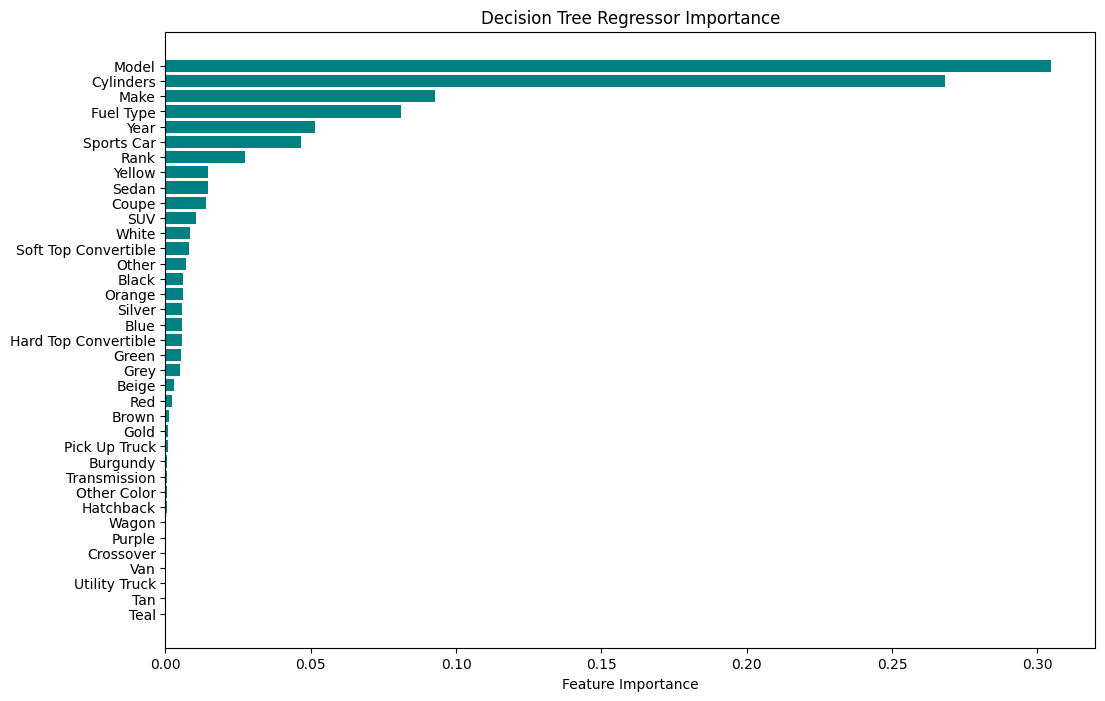

In [18]:
# acquiring feature importance
decision_tree_importances = decision_tree_model.feature_importances_
decision_tree_features = X.columns

# creating feature importances dataframe
decision_tree_features_importances = pd.DataFrame({'Feature': decision_tree_features, 'Importance': decision_tree_importances})
decision_tree_features_importances = decision_tree_features_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(decision_tree_features_importances['Feature'], decision_tree_features_importances['Importance'], color='teal')
plt.xlabel('Feature Importance')
plt.title('Decision Tree Regressor Importance')
plt.gca().invert_yaxis()
plt.show()


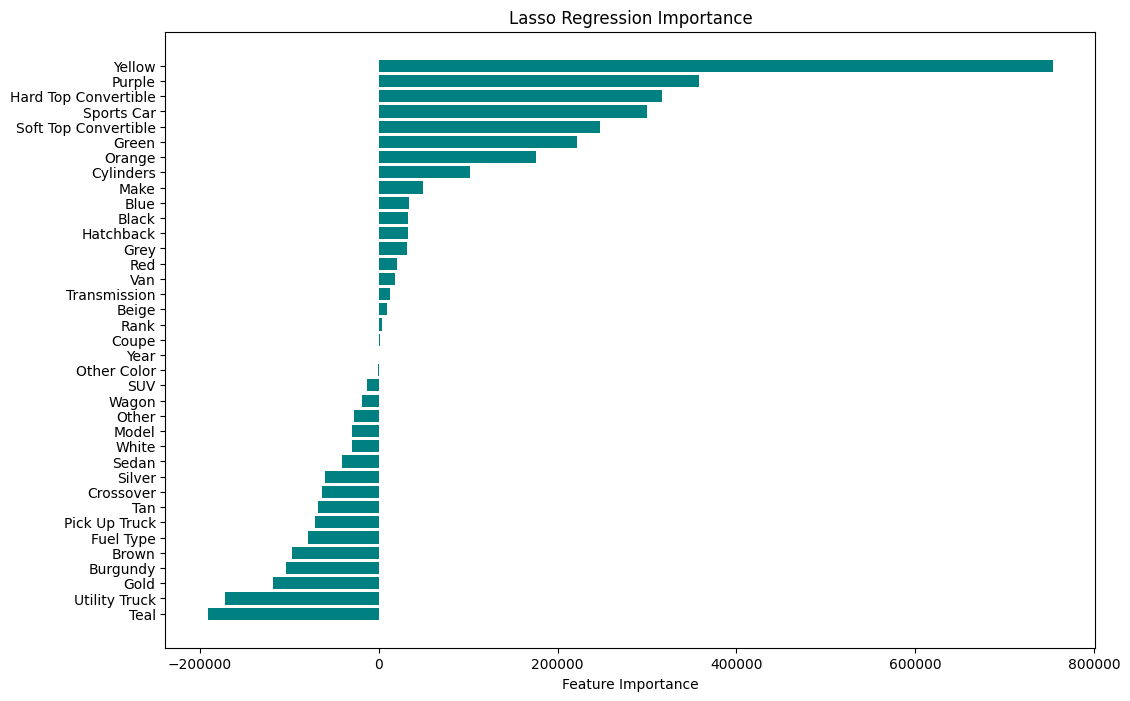

In [19]:
# acquiring feature importance
linear_regression_importances = lasso_model.coef_
linear_regression_features = X.columns

# creating feature importances dataframe
linear_regression_features_importances = pd.DataFrame({'Feature': linear_regression_features, 'Importance': linear_regression_importances})
linear_regression_features_importances = linear_regression_features_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(linear_regression_features_importances['Feature'], linear_regression_features_importances['Importance'], color='teal')
plt.xlabel('Feature Importance')
plt.title('Lasso Regression Importance')
plt.gca().invert_yaxis()
plt.show()



#### Feature Selection

In [20]:
 # Select top 5 features based on correlation with the target
selected_dt_features = [feature for feature, importance in zip(X.columns, decision_tree_importances) if importance > 0.05]
print("Selected Features (Decision Tree):", selected_dt_features)

Selected Features (Decision Tree): ['Make', 'Model', 'Year', 'Cylinders', 'Fuel Type']


In [21]:
# parameter grid for all three models
param_grid = {
    'LassoRegression': {
        'alpha': np.logspace(-6, 3, 10),  # from 1e-6 to 1e3, log scale
        'fit_intercept': [True, False],
        'max_iter': [1000, 5000, 10000, 20000],
        'tol': [1e-4, 1e-3, 1e-2],  # tolerance for stopping criteria
        'selection': ['cyclic', 'random'],  # coordinate descent update rule
    },
    'SupportVectorRegressor': {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': [0.01, 0.1, 1, 10, 100, 1000],
        'epsilon': [0.001, 0.01, 0.1, 0.2, 0.5],
        'gamma': ['scale', 'auto', 0.01, 0.001]
    },
    'DecisionTreeRegressor': {
        'splitter': ['best', 'random'],
        'max_depth': [None, 3, 5, 7, 10, 15, 20],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': [None, 'sqrt', 'log2', 0.5, 0.8]
    }
}

In [22]:
# best parameter search and results for the lasso regression model
lasso_grid_search = GridSearchCV(lasso_model, param_grid['LassoRegression'], cv=5, scoring='r2', verbose=10)
lasso_grid_search.fit(X_train[selected_dt_features], y_train)
print("Lasso Regression Best Parameters:", lasso_grid_search.best_params_)
print("Performance:")
y_pred_lasso = evaluate_model(lasso_grid_search.best_estimator_,X_train[selected_dt_features], y_train, X_test[selected_dt_features], y_test)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV 1/5; 1/480] START alpha=1e-06, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 1/5; 1/480] END alpha=1e-06, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.175 total time=   0.0s
[CV 2/5; 1/480] START alpha=1e-06, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 2/5; 1/480] END alpha=1e-06, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.180 total time=   0.0s
[CV 3/5; 1/480] START alpha=1e-06, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 3/5; 1/480] END alpha=1e-06, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.279 total time=   0.0s
[CV 4/5; 1/480] START alpha=1e-06, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 4/5; 1/480] END alpha=1e-06, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.279 total time=   0.0s
[CV 5/5; 1/480] STAR

In [23]:
# best parameter search and results for the support vector regressor model
svr_grid_search = GridSearchCV(svr_model, param_grid['SupportVectorRegressor'], cv=5, scoring='r2', verbose=10)
svr_grid_search.fit(X_train[selected_dt_features], y_train)
print("Support Vector Regressor Best Parameters:", svr_grid_search.best_params_)
print("Performance:")
y_pred_svr = evaluate_model(svr_grid_search.best_estimator_,X_train[selected_dt_features], y_train, X_test[selected_dt_features], y_test)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV 1/5; 1/360] START C=0.01, epsilon=0.001, gamma=scale, kernel=linear.........
[CV 1/5; 1/360] END C=0.01, epsilon=0.001, gamma=scale, kernel=linear;, score=-0.081 total time=   0.5s
[CV 2/5; 1/360] START C=0.01, epsilon=0.001, gamma=scale, kernel=linear.........
[CV 2/5; 1/360] END C=0.01, epsilon=0.001, gamma=scale, kernel=linear;, score=-0.079 total time=   0.5s
[CV 3/5; 1/360] START C=0.01, epsilon=0.001, gamma=scale, kernel=linear.........
[CV 3/5; 1/360] END C=0.01, epsilon=0.001, gamma=scale, kernel=linear;, score=-0.122 total time=   0.5s
[CV 4/5; 1/360] START C=0.01, epsilon=0.001, gamma=scale, kernel=linear.........
[CV 4/5; 1/360] END C=0.01, epsilon=0.001, gamma=scale, kernel=linear;, score=-0.106 total time=   0.5s
[CV 5/5; 1/360] START C=0.01, epsilon=0.001, gamma=scale, kernel=linear.........
[CV 5/5; 1/360] END C=0.01, epsilon=0.001, gamma=scale, kernel=linear;, score=-0.130 total time=   0.5s
[CV 1/5; 2/

In [24]:
# best parameter search and results for the decision tree regressor model
decision_tree_grid_search = GridSearchCV(decision_tree_model, param_grid['DecisionTreeRegressor'], cv=5, scoring='r2', verbose=10)
decision_tree_grid_search.fit(X_train[selected_dt_features], y_train)
print("Decision Tree Regressor Best Parameters:", decision_tree_grid_search.best_params_)
print("Performance:")
y_pred_dt = evaluate_model(decision_tree_grid_search.best_estimator_,X_train[selected_dt_features], y_train, X_test[selected_dt_features], y_test)

Fitting 5 folds for each of 1120 candidates, totalling 5600 fits
[CV 1/5; 1/1120] START max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=best
[CV 1/5; 1/1120] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=best;, score=0.524 total time=   0.0s
[CV 2/5; 1/1120] START max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=best
[CV 2/5; 1/1120] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=best;, score=0.458 total time=   0.0s
[CV 3/5; 1/1120] START max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=best
[CV 3/5; 1/1120] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=best;, score=0.612 total time=   0.0s
[CV 4/5; 1/1120] START max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=best
[CV 4/5; 1/1120] END max_depth=None, max_features=N

In [25]:
# stack of estimators with a final regressor.
stacking = StackingRegressor(
    estimators=[
        ('lassoreg', lasso_grid_search.best_estimator_),
        ('svr', svr_grid_search.best_estimator_),
        ('dectr', decision_tree_grid_search.best_estimator_)
    ],
    final_estimator=Lasso()
)

# ensemble meta-estimator that fits several base regressors, each on the whole dataset 
# then averages individual predictions to form final prediction.
voting = VotingRegressor(
    estimators=[
        ('lassoreg', lasso_grid_search.best_estimator_),
        ('svr', svr_grid_search.best_estimator_),
        ('dectr', decision_tree_grid_search.best_estimator_)
    ]
)

In [26]:
print("\nStacking Regressor Performance:")
y_pred_stacking = evaluate_model(stacking, X_train[selected_dt_features], y_train, X_test[selected_dt_features], y_test)

print("\nVoting Regressor Performance:")
y_pred_voting = evaluate_model(voting,X_train[selected_dt_features], y_train, X_test[selected_dt_features], y_test)


Stacking Regressor Performance:
MSE: 70132330899.09, MAE: 113619.50, R²: 0.74

Voting Regressor Performance:
MSE: 128030958423.59, MAE: 146176.52, R²: 0.52


In [27]:
# saving gridsearch enhanced models
joblib.dump(lasso_grid_search.best_estimator_, '../models/gridsearchEli/best_lasso_regression_model.pkl')
joblib.dump(svr_grid_search.best_estimator_, '../models/gridsearchEli/best_support_vector_regressor_model.pkl')
joblib.dump(decision_tree_grid_search.best_estimator_, '../models/gridsearchEli/best_decision_tree_regressor_model.pkl')

# saving stacking and voting regressors
joblib.dump(stacking, '../models/gridsearchEli/lasso_svr_dec_stacking_regressor.pkl')
joblib.dump(voting, '../models/gridsearchEli/lasso_svr_dec_voting_regressor.pkl')

['../models/gridsearchEli/lasso_svr_dec_voting_regressor.pkl']


Stacking Regressor Performance:


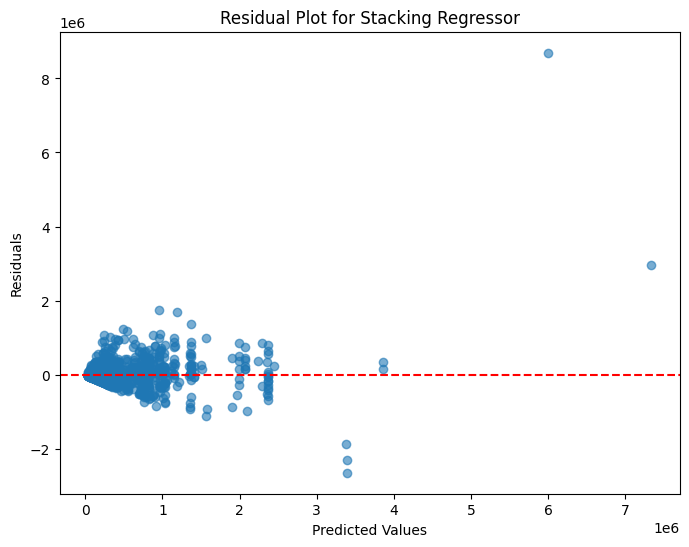

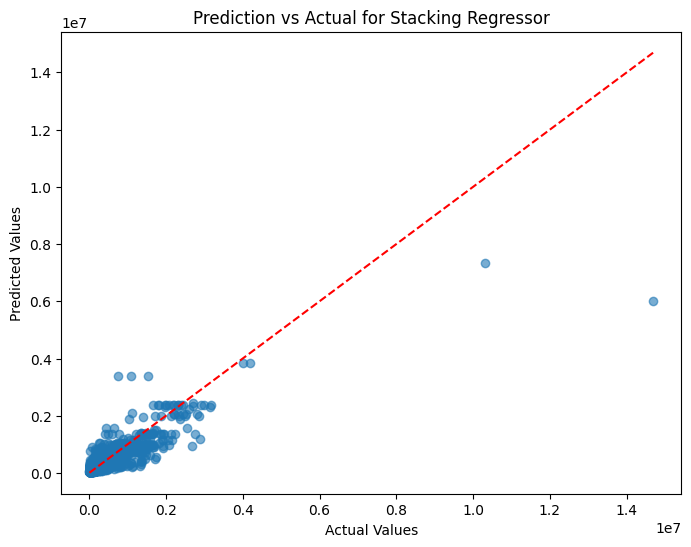

In [38]:
# evaluation plots for stacking regressor
print("\nStacking Regressor Performance:")
plot_residuals(y_test, y_pred_stacking, "Stacking Regressor")
plot_prediction_vs_actual(y_test, y_pred_stacking, "Stacking Regressor")


Voting Regressor Performance:


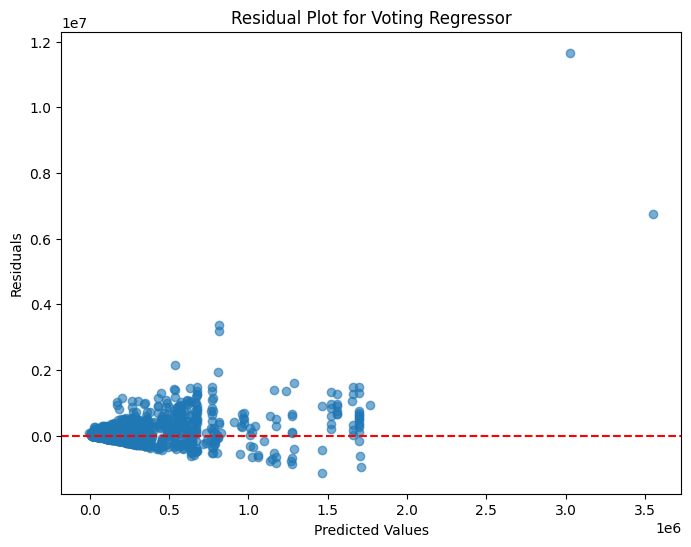

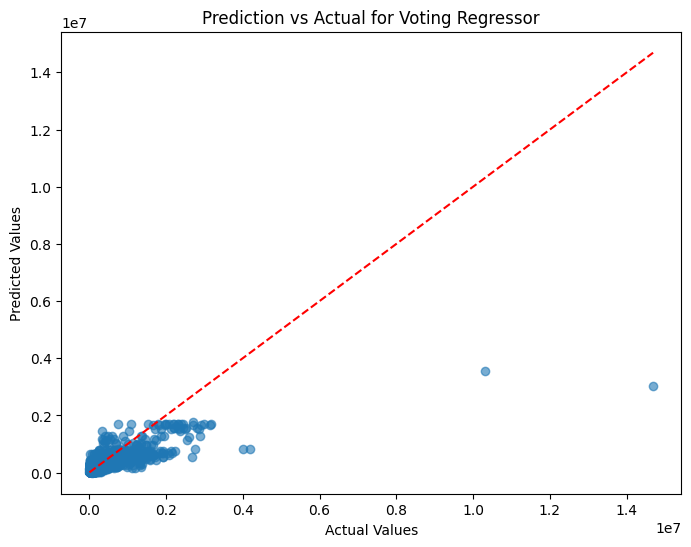

In [39]:
# evaluation plots for voting regressor
print("\nVoting Regressor Performance:")
plot_residuals(y_test, y_pred_voting, "Voting Regressor")
plot_prediction_vs_actual(y_test, y_pred_voting, "Voting Regressor")